Introduction
This notebook will demonstrate how to perform a sentimental analysis using different Deep Learning techniques. As a beginner with Deep Learning Techniques for NLP, I won't use the most sophisticated techniques available out there. However, I'll explain the basics needed to face an NLP project.

The data that I will be working with in this notebook will be from a Women's Clothing E-Commerce store revolving around the reviews written by customers on their different products. If you want to know more about it, you can click here.

For this project, I'll show the performance of the Recurrent Neural Networks (RNN) and Long Short Term Memory networks (LSTM's) techniques for NPL. Previous to that, I'll display a simple EDA to understand the basics of the dataset and preprocess it for the models.

In [1]:
# Importing necessary libraries for preprocessing & EDA
import numpy as np
import pandas as pd
from plotly import graph_objs as go

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [2]:
df.drop(columns = ['Unnamed: 0'],inplace=True)

In [3]:
df.shape

(23486, 10)

In [4]:
print('Number of Duplicates:', len(df[df.duplicated()]))

Number of Duplicates: 21


In [5]:
print(f"Null values in dataframe \n {df.isnull().sum()}")

Null values in dataframe 
 Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [6]:
df = df.dropna(subset = ['Review Text', 'Division Name', 'Department Name', 'Class Name'])

In [7]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

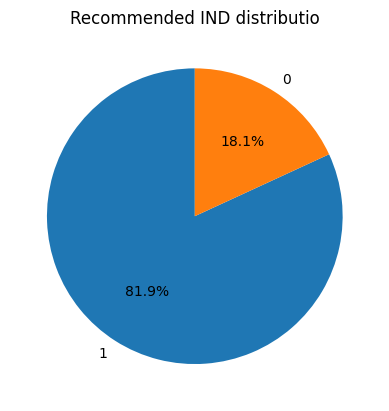

In [9]:
binary_count = df['Recommended IND'].value_counts()
plt.pie(binary_count,labels = binary_count.index,autopct = '%1.1f%%',startangle=90)
plt.title("Recommended IND distributio")
plt.show()

In [10]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


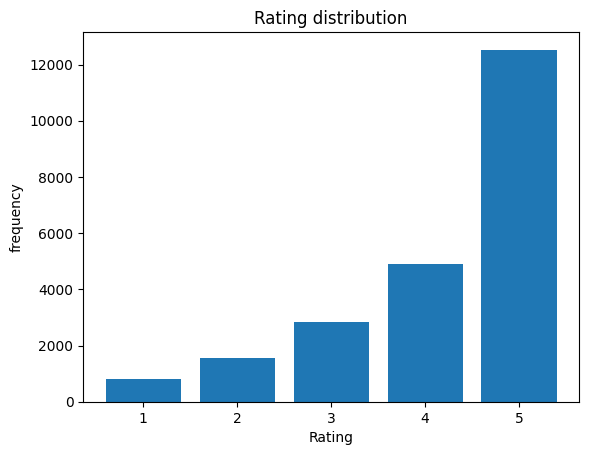

In [11]:
rating_counts = df['Rating'].value_counts()
rating_counts = rating_counts.sort_index()


plt.bar(rating_counts.index,rating_counts)
plt.xlabel('Rating')
plt.ylabel('frequency')
plt.title('Rating distribution')
plt.show()

In [12]:
# Necessary libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics

import re
import string

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
data = df[['Review Text', 'Recommended IND']]


In [14]:
# Cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
data['Review Text'] = data['Review Text'].apply(lambda x:clean_text(x))


In [16]:
# Setting up the evaluation metrics
def roc_auc(predictions,target):

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [17]:
# Split target & features
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND']

# Spliting train & test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [18]:
# Keras takenization text data prep

num_words = None   # the most X frequent words is returned

# Tokenize data
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train['Review Text'].tolist() + X_test['Review Text'].tolist())   # introduce text in list

# Get data word index
word_index = tokenizer.word_index

# Encode training/test data sentences into sequences
X_train_seq = tokenizer.texts_to_sequences(X_train['Review Text'].tolist())
X_test_seq = tokenizer.texts_to_sequences(X_test['Review Text'].tolist())

# Get max training sequence length
max_len = max([len(x) for x in X_train_seq])

# Pad the training/test sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Output some results
print("\nPadded training shape:", X_train_pad.shape)
print("\nPadded test shape:", X_test_pad.shape)


Padded training shape: (18102, 112)

Padded test shape: (4526, 112)


In [19]:
# Basic RNN
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    50,     # embeds it in a 50-dimensional vector
                    input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 50)           1022500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               15100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,037,701
Trainable params: 1,037,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 512

model.fit(X_train_pad, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
36/36 [==============================] - 16s 323ms/step - loss: 0.5088 - accuracy: 0.7988
Epoch 2/5
36/36 [==============================] - 13s 367ms/step - loss: 0.4467 - accuracy: 0.8187
Epoch 3/5
36/36 [==============================] - 12s 340ms/step - loss: 0.3902 - accuracy: 0.8301
Epoch 4/5
36/36 [==============================] - 14s 404ms/step - loss: 0.3102 - accuracy: 0.8647
Epoch 5/5
36/36 [==============================] - 15s 410ms/step - loss: 0.2141 - accuracy: 0.9133


In [21]:
scores = model.predict(X_test_pad)
print("AUC: %.2f%%" % (roc_auc(scores,y_test)))


142/142 [==============================] - 2s 14ms/step
AUC: 0.91%


# LSTM

In [22]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    50,     # embeds it in a 50-dimensional vector
                    input_length=max_len))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 112, 50)           1022500   
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,083,001
Trainable params: 1,083,001
Non-trainable params: 0
_________________________________________________________________


In [23]:
batch_size = 512

model.fit(X_train_pad, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
36/36 [==============================] - 71s 2s/step - loss: 0.5156 - accuracy: 0.8110
Epoch 2/5
36/36 [==============================] - 63s 2s/step - loss: 0.3766 - accuracy: 0.8337
Epoch 3/5
36/36 [==============================] - 62s 2s/step - loss: 0.2677 - accuracy: 0.8807
Epoch 4/5
36/36 [==============================] - 63s 2s/step - loss: 0.2131 - accuracy: 0.9082
Epoch 5/5
36/36 [==============================] - 63s 2s/step - loss: 0.1850 - accuracy: 0.9226


In [24]:
scores = model.predict(X_test_pad)
print("AUC: %.2f%%" % (roc_auc(scores,y_test)))

142/142 [==============================] - 8s 51ms/step
AUC: 0.93%


# Alternative Approach

In [31]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [32]:
df['Title']=df['Title'].fillna('')

In [33]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [34]:
df['Review Text'] = df['Review Text']+df['Title']

In [35]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [36]:
data = df[['Review Text', 'Rating']]


In [37]:
data['Review Text'] = data['Review Text'].apply(lambda x:clean_text(x))


In [38]:
X = data.drop('Rating', axis=1)
y = data['Rating']

# Spliting train & test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [39]:
# Keras takenization text data prep

num_words = None   # the most X frequent words is returned

# Tokenize data
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train['Review Text'].tolist() + X_test['Review Text'].tolist())   # introduce text in list

# Get data word index
word_index = tokenizer.word_index

# Encode training/test data sentences into sequences
X_train_seq = tokenizer.texts_to_sequences(X_train['Review Text'].tolist())
X_test_seq = tokenizer.texts_to_sequences(X_test['Review Text'].tolist())

# Get max training sequence length
max_len = max([len(x) for x in X_train_seq])

# Pad the training/test sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Output some results
print("\nPadded training shape:", X_train_pad.shape)
print("\nPadded test shape:", X_test_pad.shape)


Padded training shape: (18788, 116)

Padded test shape: (4698, 116)


In [41]:
# Basic RNN
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    50,     # embeds it in a 50-dimensional vector
                    input_length=max_len))
model.add(SimpleRNN(100,return_sequences=True))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 116, 50)           1668800   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 116, 100)          15100     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,704,101
Trainable params: 1,704,101
Non-trainable params: 0
_________________________________________________________________


In [42]:
batch_size = 512

model.fit(X_train_pad, y_train, epochs=7, batch_size=batch_size,validation_split=0.2)

Epoch 1/7
30/30 [==============================] - 26s 752ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 2/7
30/30 [==============================] - 21s 705ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 3/7
30/30 [==============================] - 29s 997ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 4/7
30/30 [==============================] - 28s 920ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 5/7
30/30 [==============================] - 22s 731ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 6/7
30/30 [==============================] - 21s 684ms/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 7/7
30/30 [==============================] - 23s 779ms/step - loss: 0.0000e+00 - accuracy: 0.0

In [44]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    50,     # embeds it in a 50-dimensional vector
                    input_length=max_len))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 116, 50)           1668800   
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,729,301
Trainable params: 1,729,301
Non-trainable params: 0
_________________________________________________________________


In [45]:
batch_size = 512

model.fit(X_train_pad, y_train, epochs=5, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
30/30 [==============================] - 64s 2s/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 2/5
30/30 [==============================] - 59s 2s/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 3/5
30/30 [==============================] - 58s 2s/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 4/5
30/30 [==============================] - 58s 2s/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
Epoch 5/5
30/30 [==============================] - 57s 2s/step - loss: 0.0000e+00 - accuracy: 0.0356 - val_loss: 0.0000e+00 - val_accuracy: 0.0370
